# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance

In [3]:
!pip install palmerpenguins
from palmerpenguins import load_penguins

df = load_penguins()
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [ ]:
na_count = df.isna().sum()
na_count

,0
species,0
island,0
bill_length_mm,0
bill_depth_mm,0
flipper_length_mm,0
body_mass_g,0
sex,0
year,0


In [4]:
df.dropna(inplace=True)

In [ ]:
df['year'].unique()

array([2007, 2008, 2009])

In [5]:
species_dummies = pd.get_dummies(df[['island', 'species']])

# Optionally, you can concatenate the dummy variables with the original DataFrame
df = pd.concat([df, species_dummies], axis=1)
# df['2007'] = df['year'].map({'2007':1, '2008':0, '2009':0})
# df['2008'] = df['year'].map({'2007':0, '2008':1, '2009':0})
# df['2009'] = df['year'].map({'2007':0, '2008':0, '2009':1})
df = pd.get_dummies(df, columns=['year'], prefix='', prefix_sep='')
df = pd.get_dummies(df, columns=['sex'], prefix='', prefix_sep='', sparse=True)

# Create dummy variables for each year
# df['2007'] = df['year'].map({'2007': 1, '2008': 0, '2009': 0})
# df['2008'] = df['year'].map({'2007': 0, '2008': 1, '2009': 0})
# df['2009'] = df['year'].map({'2007': 0, '2008': 0, '2009': 1})

df = df.drop(columns=[ 'island','male'])


df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,species_Adelie,species_Chinstrap,species_Gentoo,2007,2008,2009,female
0,Adelie,39.1,18.7,181.0,3750.0,False,False,True,True,False,False,True,False,False,False
1,Adelie,39.5,17.4,186.0,3800.0,False,False,True,True,False,False,True,False,False,True
2,Adelie,40.3,18.0,195.0,3250.0,False,False,True,True,False,False,True,False,False,True
4,Adelie,36.7,19.3,193.0,3450.0,False,False,True,True,False,False,True,False,False,True
5,Adelie,39.3,20.6,190.0,3650.0,False,False,True,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,Chinstrap,55.8,19.8,207.0,4000.0,False,True,False,False,True,False,False,False,True,False
340,Chinstrap,43.5,18.1,202.0,3400.0,False,True,False,False,True,False,False,False,True,True
341,Chinstrap,49.6,18.2,193.0,3775.0,False,True,False,False,True,False,False,False,True,False
342,Chinstrap,50.8,19.0,210.0,4100.0,False,True,False,False,True,False,False,False,True,False


In [ ]:
df.dtypes

,0
bill_length_mm,float64
bill_depth_mm,float64
flipper_length_mm,float64
body_mass_g,float64
island_Biscoe,bool
island_Dream,bool
island_Torgersen,bool
species_Adelie,bool
species_Chinstrap,bool
species_Gentoo,bool


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [20]:
# Split data into features and target
X = df.drop(['species', 'species_Adelie',	'species_Chinstrap',	'species_Gentoo'], axis=1)  # Features
y = df[['species']]              # Target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
from sklearn.impute import SimpleImputer

In [8]:
X_train = X_train.sparse.to_dense() if hasattr(X_train, 'sparse') else X_train
X_test = X_test.sparse.to_dense() if hasattr(X_test, 'sparse') else X_test

y_train = y_train.values.ravel() if hasattr(y_train, 'values') else y_train.ravel()

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


# Create the KNN pipeline
knn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ("knn", KNeighborsClassifier(n_neighbors=1))  # KNN Classifier
])

# Train the pipeline
knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = knn_pipeline.predict(X_test)

roc_auc_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring="accuracy")

# Output the mean ROC AUC score across folds
print("ROC AUC Scores for each fold:", roc_auc_scores)
print("Mean ROC AUC Score:", roc_auc_scores.mean())

# Generate the confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_knn)

# Optional: Add a classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ROC AUC Scores for each fold: [0.83333333 0.73584906 0.79245283 0.8490566  0.77358491]
Mean ROC AUC Score: 0.7968553459119497
Confusion Matrix:
[[24  6  1]
 [ 6 11  1]
 [ 0  1 17]]

Classification Report:
              precision    recall  f1-score   support

      Adelie       0.80      0.77      0.79        31
   Chinstrap       0.61      0.61      0.61        18
      Gentoo       0.89      0.94      0.92        18

    accuracy                           0.78        67
   macro avg       0.77      0.78      0.77        67
weighted avg       0.77      0.78      0.78        67



In [21]:
# Create the KNN pipeline
knn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ("knn", KNeighborsClassifier(n_neighbors=5))  # KNN Classifier
])

# Train the pipeline
knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = knn_pipeline.predict(X_test)

roc_auc_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring="accuracy")

# Output the mean ROC AUC score across folds
print("ROC AUC Scores for each fold:", roc_auc_scores)
print("Mean ROC AUC Score:", roc_auc_scores.mean())

# Generate the confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_knn)

# Optional: Add a classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ROC AUC Scores for each fold: [0.81481481 0.71698113 0.77358491 0.77358491 0.77358491]
Mean ROC AUC Score: 0.7705101327742837
Confusion Matrix:
[[25  1  3]
 [10  3  1]
 [ 3  0 21]]

Classification Report:
              precision    recall  f1-score   support

      Adelie       0.66      0.86      0.75        29
   Chinstrap       0.75      0.21      0.33        14
      Gentoo       0.84      0.88      0.86        24

    accuracy                           0.73        67
   macro avg       0.75      0.65      0.65        67
weighted avg       0.74      0.73      0.70        67



Decison Tree:

In [22]:
dt_pipeline = Pipeline([
    ("decision_tree", DecisionTreeClassifier(random_state=42,
        max_depth=5,  # Limit depth to 5
        min_samples_split=10,  # Require at least 10 samples to split
        min_samples_leaf=5))
])
# Fit the pipeline on training data
dt_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_pipeline.predict(X_test)

## ROC AUC Scores
roc_auc_scores = cross_val_score(dt_pipeline, X_train, y_train, cv=5, scoring="accuracy")

# Output the mean ROC AUC score across folds
print("ROC AUC Scores for each fold:", roc_auc_scores)
print("Mean ROC AUC Score:", roc_auc_scores.mean())

# Generate the confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_knn)



# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

ROC AUC Scores for each fold: [1.         0.9245283  0.96226415 0.94339623 0.88679245]
Mean ROC AUC Score: 0.9433962264150942
Confusion Matrix:
[[25  1  3]
 [10  3  1]
 [ 3  0 21]]
Accuracy: 0.9402985074626866
Classification Report:
               precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
   Chinstrap       0.81      0.93      0.87        14
      Gentoo       1.00      0.92      0.96        24

    accuracy                           0.94        67
   macro avg       0.93      0.94      0.93        67
weighted avg       0.95      0.94      0.94        67



In [23]:
dt_pipeline = Pipeline([
    ("decision_tree", DecisionTreeClassifier(random_state=42,
        max_depth=2,  # Limit depth to 5
        min_samples_split=5,  # Require at least 10 samples to split
        min_samples_leaf=3))
])
# Fit the pipeline on training data
dt_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_pipeline.predict(X_test)

## ROC AUC Scores
roc_auc_scores = cross_val_score(dt_pipeline, X_train, y_train, cv=5, scoring="accuracy")

# Output the mean ROC AUC score across folds
print("ROC AUC Scores for each fold:", roc_auc_scores)
print("Mean ROC AUC Score:", roc_auc_scores.mean())

# Generate the confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_knn)



# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

ROC AUC Scores for each fold: [1.         0.96226415 0.96226415 0.94339623 0.90566038]
Mean ROC AUC Score: 0.9547169811320755
Confusion Matrix:
[[25  1  3]
 [10  3  1]
 [ 3  0 21]]
Accuracy: 0.9402985074626866
Classification Report:
               precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
   Chinstrap       0.81      0.93      0.87        14
      Gentoo       1.00      0.92      0.96        24

    accuracy                           0.94        67
   macro avg       0.93      0.94      0.93        67
weighted avg       0.95      0.94      0.94        67



In [15]:
print(dt_pipeline.named_steps["decision_tree"].classes_)


['Adelie' 'Chinstrap' 'Gentoo']


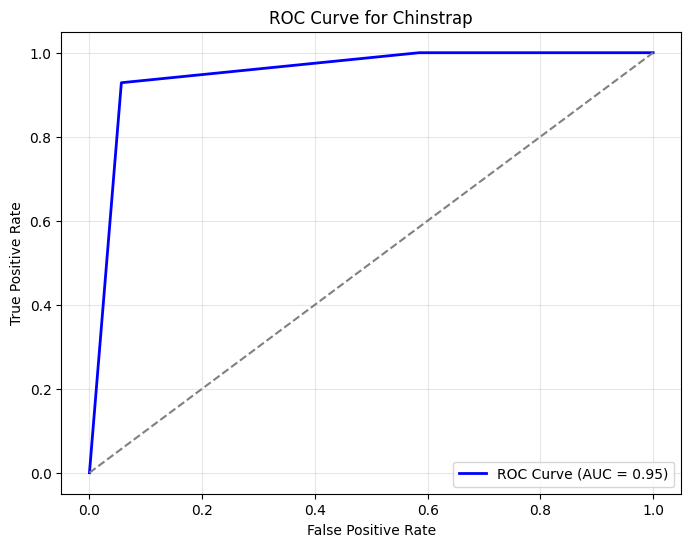

In [24]:
# Define the class of interest by name
class_of_interest = "Chinstrap"  # Replace with the desired species name

# Get the index of the class of interest
class_order = dt_pipeline.named_steps["decision_tree"].classes_
class_index = list(class_order).index(class_of_interest)

# Get probabilities for the class of interest
y_scores = dt_pipeline.predict_proba(X_test)[:, class_index]

# Convert y_test to binary (1 for class of interest, 0 for others)
y_test_binary = (y_test == class_of_interest).astype(int)

# Compute the ROC curve and AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for {class_of_interest}")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()